# [MPRG] Auto Encoderによる画像の復元とデノイジング


---
## 目的

Auto Encoder (AE)を用いることで，画像の復元とデノイジング (ノイズの除去)を行う．今回は， MNIST Datasetに対して人為的にスパイクノイズを付与し，画像の復元とデノイジングを行う．

## 準備

### Google Colaboratoryの設定確認・変更
本チュートリアルではChainerを利用してニューラルネットワークの実装を確認，学習および評価を行います．
**GPUを用いて処理を行うために，上部のメニューバーの「ランタイム」→「ランタイムのタイプを変更」からハードウェアアクセラレータをGPUにしてください．**


## モジュールのインポート
はじめに必要なモジュールをインポートする．

### GPUの確認
GPUを使用した計算が可能かどうかを確認します．

`GPU availability: True`と表示されれば，GPUを使用した計算をChainerで行うことが可能です．
Falseとなっている場合は，上記の「Google Colaboratoryの設定確認・変更」に記載している手順にしたがって，設定を変更した後に，モジュールのインポートから始めてください．

In [0]:
# モジュールのインポート
from time import time
import numpy as np
import matplotlib.pyplot as plt
import chainer
from chainer import cuda, optimizers
from chainer import Chain, Variable
import chainer.functions as F
import chainer.links as L

# GPUの確認
print('GPU availability:', chainer.cuda.available)
print('cuDNN availablility:', chainer.cuda.cudnn_enabled)

## データセットの読み込み・ノイズの付与

学習データ（MNISTデータセット）を読み込みます．
今回の実験では，各画像の正解ラベル（0, 1, 2, 3, ...）は必要ないため，ラベルの変数に相当する箇所を`_`に指定することで，変数として保存しないように記述しています．

In [0]:
train_dataset, test_dataset = chainer.datasets.get_mnist()
train_data, _ = train_dataset._datasets
test_data, _ = test_dataset._datasets

print(train_x.shape)
print(test_x.shape)

### ノイズの付与
MNISTデータセットにスパイクノイズを付与します．
スパイクノイズは乱数のマスクを作成し，学習サンプルとマスクの値を掛け合わせることでノイズを付与します．


In [0]:
noise_ratio = 0.5
rng = np.random.RandomState(1)

# 学習データへのノイズの付与
train_noise = train_data.copy()
mask = rng.binomial(size=train_noise.shape, n=1, p=1.-noise_ratio)
mask = mask.astype(np.float32)
train_noise = mask * train_noise

# テストデータへのノイズの付与
test_noise = test_data.copy()
mask = rng.binomial(size=test_noise.shape,n=1,p=1.-noise_ratio)
mask = mask.astype(np.float32)
test_noise = mask * test_noise

### データセットの表示
ノイズを付与する前後の画像を表示してみます．
ここでは，matplotlibを用いて複数の画像を表示させるプログラムを利用します．

<Figure size 432x288 with 0 Axes>

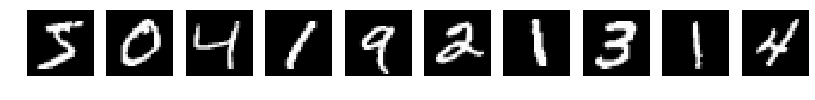

<Figure size 432x288 with 0 Axes>

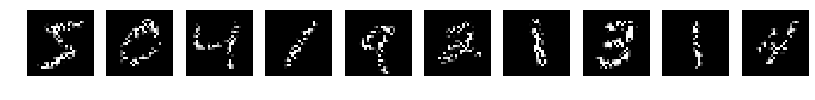

In [0]:
cols = 10

plt.clf()
fig = plt.figure(figsize=(14, 1.4))
for c in range(cols):
  ax = fig.add_subplot(1, cols, c + 1)
  ax.imshow(train_data[c].reshape(28, 28), cmap=plt.get_cmap('gray'))
  ax.set_axis_off()
plt.show()

plt.clf()
fig = plt.figure(figsize=(14, 1.4))
for c in range(cols):
  ax = fig.add_subplot(1, cols, c + 1)
  ax.imshow(train_noise[c].reshape(28, 28), cmap=plt.get_cmap('gray'))
  ax.set_axis_off()
plt.show()

## ネットワークモデルの定義

Auto Encoderの定義をします．

今回は入力層，中間層1層，出力層の3層で構成されるネットワークを定義します．

In [0]:
class AutoEncoder(chainer.Chain):
  def __init__(self, n_inputs, n_hidden):
    super(AutoEncoder, self).__init__()
    with self.init_scope():
      self.encoder = L.Linear(n_inputs,n_hidden)
      self.decoder = L.Linear(n_hidden,n_inputs)
      
  def __call__(self, x):
    h = F.sigmoid(self.encoder(x))
    y = F.sigmoid(self.decoder(h))
    return y

## ネットワークの作成
上で定義したネットワークを作成します．

入力層のサイズ（input_num）と中間層のサイズ（hidden_num）を定義し，AutoEncoderのネットワークを作成します．
その後，modelをGPUに送るto_gpu関数を利用しています．

また，最適化手法としてAdamを使用し，setup関数にネットワークモデルを与えます．

In [0]:
input_num = 784
hidden_num = 100

model = AutoEncoder(n_inputs=input_num, n_hidden=hidden_num)
model.to_gpu()

optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

ここでは，GPUに対応した行列演算モジュールのcupyを呼び出しており，学習およびテストデータをcupyの形式に変換します． cupyはnumpyと互換性があります．

In [0]:
xp = cuda.cupy
train_x = xp.array(train_noise, dtype=xp.float32)
train_t = xp.array(train_data, dtype=xp.float32)
test_x = xp.array(test_noise, dtype=xp.float32)

## 学習
１回の誤差を算出するデータ数（ミニバッチサイズ）を100，学習エポック数を10とします．

学習データサイズを取得し，1エポック内における更新回数を求めます．

学習データは毎エポックでランダムに利用するため，numpyのpermutationという関数を利用します．

各更新において，学習用データと教師データをそれぞれxとtとし，to_gpu関数でGPUに転送します．学習モデルにxを与えて各クラスの確率yを取得します．

各クラスの確率yと教師ラベルtとの誤差をmean squared error誤差関数で算出します．
そして，誤差をbackward関数で逆伝播し，ネットワークの更新を行います．

In [0]:
batch_size = 100
epoch_num = 10

train_data_num = train_x.shape[0]

start = time()
for epoch in range(epoch_num):
  total_loss = 0.0
  
  perm = np.random.permutation(train_data_num)
  for i in range(0, train_data_num, batch_size):
    x = Variable(train_x[perm[i:i+batch_size]])
    t = Variable(train_t[perm[i:i+batch_size]])
    
    y = model(x)
    model.zerograds()
    loss = F.mean_squared_error(y, t)
    loss.backward()
    optimizer.update()
    
    total_loss += loss.data * batch_size

  elapsed_time = time() - start
  print("epoch: {}, mean loss: {}, elapsed time: {}".format(epoch+1, total_loss/train_data_num, elapsed_time))

epoch: 1, mean loss: 0.05852162, elapsed time: 2.9887187480926514
epoch: 2, mean loss: 0.03443361, elapsed time: 5.716990947723389
epoch: 3, mean loss: 0.027195595, elapsed time: 8.463796854019165
epoch: 4, mean loss: 0.023457658, elapsed time: 11.225605726242065
epoch: 5, mean loss: 0.021353733, elapsed time: 13.967331409454346
epoch: 6, mean loss: 0.020051839, elapsed time: 16.683161735534668
epoch: 7, mean loss: 0.019151539, elapsed time: 19.46200156211853
epoch: 8, mean loss: 0.018482018, elapsed time: 22.225440502166748
epoch: 9, mean loss: 0.017954651, elapsed time: 24.974140882492065
epoch: 10, mean loss: 0.017524848, elapsed time: 27.745434999465942


## テスト

学習したネットワークモデルを用いてデノイジングを行います．

ノイズを付与したデータをネットワークへ入力し，その出力をtest_resultへ保存していきます．
この時，ネットワークからの出力結果はGPUのメモリ上へ格納されているため，cuda.to_cpu関数を用いて通常のCPU側のメモリへと移動させた後に，test_resultへと格納します．

In [0]:
test_data_num = test_x.shape[0]
test_result = []

for i in range(test_data_num):
  x = Variable(cuda.to_gpu(test_x[i].reshape(1, -1)))
  y = model(x)
  test_result.append(cuda.to_cpu(y.data))

デノイジングの結果を表示してみます．
表示にはmatplotlibを用います．


<Figure size 432x288 with 0 Axes>

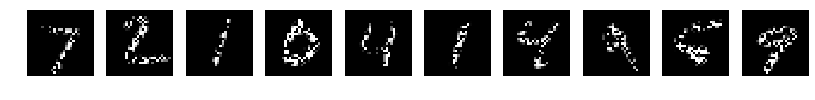

<Figure size 432x288 with 0 Axes>

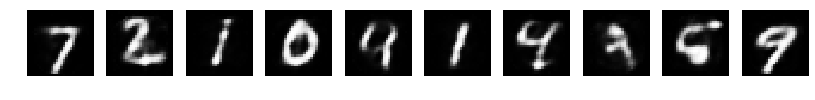

In [0]:
plt.clf()
fig = plt.figure(figsize=(14, 1.4))
for c in range(cols):
  ax = fig.add_subplot(1, cols, c + 1)
  ax.imshow(test_noise[c].reshape(28, 28), cmap=plt.get_cmap('gray'))
  ax.set_axis_off()
plt.show()

plt.clf()
fig = plt.figure(figsize=(14, 1.4))
for c in range(cols):
  ax = fig.add_subplot(1, cols, c + 1)
  ax.imshow(test_result[c][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
  ax.set_axis_off()
plt.show()

## 課題
1. 中間層のユニット数を変更した時の性能を比較せよ．
2. EncoderとDecoderの層数を1層追加した際の出力結果を比較せよ．

## ヒント
2. class AutoEncoderで，encoderとdecoderをそれぞれ1層追加する．
ここで，それぞれのユニット数は，対称になるように設計する．